# Transformation des images pour l'application de UNETR puis transformation inverse

# Calcul de l'indice de Dice, spécificité, sensibilité sur les images d'entrainement, de validation et de test


## fonction de calcul des métriques

In [7]:
def diceSpecSens(maskGT, maskPred):
    predZone=np.where(maskPred==1.0, maskPred,10000)
    gtZone=np.where(maskGT==1.0, maskGT,10000)
    invPredZone=np.where(maskPred!=1.0, maskPred,10000)
    
    vp=np.where(gtZone==maskPred,1,0)
    fn=np.where(maskPred-maskGT==-1,1,0)
    fp=np.where(maskPred-maskGT==1,1,0)
    vn=np.where(invPredZone==maskGT,1,0)
    
    print(np.sum(vp), np.sum(maskPred), np.sum(maskGT))
    return (2*np.sum(vp))/(np.sum(maskPred)+np.sum(maskGT)), (np.sum(vn)/(np.sum(vn)+np.sum(fp))), (np.sum(vp)/(np.sum(vp)+np.sum(fn)))
    

## fonctions d'application de UNETR

In [39]:
def transformation():
    dtype= torch.float32
    voxel_space =(1.5, 1.5, 2.0)
    a_min=-200.0
    a_max=300
    b_min=0.0
    b_max=1.0
    clip=True
    crop_bed_max_number_of_rows_to_remove=0
    crop_bed_max_number_of_cols_to_remove=0
    crop_bed_min_spatial_size=(300, -1, -1)
    enable_fgbg2indices_feature=False
    pos=1.0
    neg=1.0
    num_samples=1
    roi_size=(96, 96, 96)
    random_flip_prob=0.2
    random_90_deg_rotation_prob=0.2
    random_intensity_scale_prob=0.1
    random_intensity_shift_prob=0.1
    val_resize=(-1, -1, 250)

    spacing = transforms.Identity()
    if all([space > 0.0 for space in voxel_space]):
        spacing = transforms.Spacingd(
            keys=["image", "label"], pixdim=voxel_space, mode=("bilinear", "nearest")
        ) # to change the dimension of the voxel to have less data to compute

        posneg_label_croper_kwargs = {
                "keys": ["image", "label"],
                "label_key": "label",
                "spatial_size": roi_size,
                "pos": pos,
                "neg": neg,
                "num_samples": num_samples,
                "image_key": "image",
                "allow_smaller": True,
        }

        fgbg2indices = transforms.Identity()
        if enable_fgbg2indices_feature:
            fgbg2indices = transforms.FgBgToIndicesd(
                    keys=["image", "label"], image_key="label", image_threshold=0.0
            ) # to crop samples close to the label mask
            posneg_label_croper_kwargs["fg_indices_key"] = "image_fg_indices"
            posneg_label_croper_kwargs["bg_indices_key"] = "image_bg_indices"
        else:
            posneg_label_croper_kwargs["image_threshold"] = 0.0

    transform = transforms.Compose(
                [
                    transforms.Orientationd(keys=["image", "label"], axcodes="LAS", allow_missing_keys=True), # to have the same orientation
                    spacing,
                    transforms.ScaleIntensityRanged(
                        keys=["image"], a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, clip=clip, allow_missing_keys=True
                    ), # scales image from a values to b values
                    CropBedd(
                        keys=["image", "label"], image_key="image",
                        max_number_of_rows_to_remove=crop_bed_max_number_of_rows_to_remove,
                        max_number_of_cols_to_remove=crop_bed_max_number_of_cols_to_remove,
                        min_spatial_size=crop_bed_min_spatial_size,
                        axcodes_orientation="LAS",
                    ), # crop the bed from the image (useless data)
                    transforms.CropForegroundd(keys=["image", "label"], source_key="image", allow_missing_keys=True), # remove useless background image part
                    fgbg2indices,
                    transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=0, allow_missing_keys=True), # random flip on the X axis
                    transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=1, allow_missing_keys=True), # random flip on the Y axis
                    transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=2, allow_missing_keys=True), # random flip on the Z axis
                    transforms.RandRotate90d(keys=["image", "label"], prob=random_90_deg_rotation_prob, max_k=3, allow_missing_keys=True), # random 90 degree rotation
                    transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=random_intensity_scale_prob), # random intensity scale
                    transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=random_intensity_shift_prob), # random intensity shifting
                    transforms.ToTensord(keys=["image", "label"], dtype=dtype), # to have a PyTorch tensor as output
                ]
            )
    return transform

def loadModel(pathModelFile):
    model= SegmentationTask.load_from_checkpoint(pathModelFile)
    model.eval()
    return model

def loadDicomImage(slices_folder):
    image=torch.tensor([LoadImage(image_only=True)(slices_folder)])
    image=((image/np.max(np.array(image)))*255)
    return image

def applyTransforms(transform, image):
    print("applyT", image.shape)
    image={"image":image, "label":torch.zeros_like(image),"patient_id":'201905984', "has_meta":True}
    image=transform(image)
    print("applyT", image['image'].shape)
    return image

def applyUNETR(dicoImage, model):
    label =sliding_window_inference(inputs=dicoImage["image"][None], 
                                            roi_size=(96, 96, 96), 
                                            sw_batch_size=4,
                                            predictor=model,
                                            overlap=0.5)

    label = torch.argmax(label, dim=1, keepdim=True)
    
    size=label.shape
    print("applyUNETR", size[1], size[2], size[3], size[4])
    dicoImage["label"]=label.reshape((size[1], size[2], size[3], size[4]))
    return dicoImage

def disapplyTransforms(transform, dicoImage):
    dicoImage = transform.inverse(dicoImage)
    return dicoImage["label"], dicoImage["image"]



def getLabelOfIRM(pathSlicesIRM, pathModelFile):
    image = loadDicomImage(pathSlicesIRM)
    transform = transformation()
    dicoImage = applyTransforms(transform, image)
    model = loadModel(pathModelFile)
    dicoImage = applyUNETR(dicoImage, model)
    label, imageT = disapplyTransforms(transform, dicoImage)
    return image/255, label, imageT

def getLabelOfIRM(image, mask, pathModelFile):
    image=torch.tensor([image])
    image=((image/np.max(np.array(image)))*255)
    transform = transformation()
    dicoImage = applyTransforms(transform, image)
    model = loadModel(pathModelFile)
    dicoImage = applyUNETR(dicoImage, model)
    label, imageT = disapplyTransforms(transform, dicoImage)
    return image/255, label, imageT

#pathSlicesIRM='/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/BaseDonnée220Patients/201905984/RM'
#pathModelFile="/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/RunAll4/checkpoints/checkpoint-epoch=1599-val_loss=0.225.ckpt"

#image, label, imageT = getLabelOfIRM(pathSlicesIRM, pathModelFile)

## calcul des métriques pour chaques patients

In [40]:
def miseEnDossier(patient_id):
    path_newDirRM = os.path.join(meta_data_dir, patient_id, "RM/")
    path_newDirMETA = os.path.join(meta_data_dir, patient_id, "META/")
    if not os.path.exists(path_newDirRM):
        os.mkdir(path_newDirRM)
    if not os.path.exists(path_newDirMETA):
        os.mkdir(path_newDirMETA)
    for mr in glob.glob(os.path.join(meta_data_dir, patient_id, "MR*")):
        path_dir, name_file= os.path.split(mr)
        os.rename(mr, str(path_newDirRM)+str(name_file))
    for rs in glob.glob(os.path.join(meta_data_dir, patient_id, "RS*")):
        path_dir, name_file= os.path.split(rs)
        os.rename(rs, str(path_newDirMETA)+str(name_file))
        
def fusionMask(mask):
        if (type(mask)==list):
            premMask = mask[0]
            for autMask in mask[1:]:
                premMask = np.where(autMask > 0, autMask, premMask)
            return premMask
        else:
            return mask
    
listeName=[]
def load_dicom_with_mask(slices_folder, mask_file):
    rt_struct = rt_utils.RTStructBuilder.create_from(slices_folder, mask_file)
    maskAllAlone=[]
    for i in rt_struct.get_roi_names():
        if "GTV" in i or "recid" in i or "FRONTAL" in i or "GTC" in i or "Cerebelleux" in i or "PARIET" in i or "gtv" in i or "M1." in i or "M2." in i or "FRONTAL" in i:
            if "patient" not in i and "POST OP" not in i and "Préop" not in i and "External" not in i and "cav" not in i and "Cav" not in i and "cavite" not in i and "cavité" not in i and "Cavité" not in i and "PTV" not in i and "ANCIEN" not in i and "Ancien" not in i and "ANC" not in i and "Anecien" not in i and "PTC" not in i:
                maskAllAlone.append(rt_struct.get_roi_mask_by_name(i).astype(np.float32))
                listeName.append(i)
    mask = fusionMask(maskAllAlone)
    img = np.array(LoadImage( image_only=True)(slices_folder))

    img = np.rot90(img)
    img = np.flip(img, 0)
    img = (img/np.max(img))*255
    return img, np.array(mask)


def load_dicom_series_without_mask(patient_folder):
    img = LoadImage( image_only=True)(patient_folder)
    mask = np.zeros_like(img)
    return np.array(img), mask
  
def filter_patients_with_meta(patient_id: str) -> bool:
    miseEnDossier(patient_id)
    # if no folder in patient directory
    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "*"))) == 0:
        return False

    # if no named folders "META" or "RM"
    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "META"))) == 0 or len(glob.glob(os.path.join(meta_data_dir, patient_id, "RM"))) == 0:
        return False
    
    # if no dicom image in the META folder
    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "META", "*"))) == 0:
        return False
    
    return True

def filter_patients_without_meta(patient_id: str) -> bool:
    miseEnDossier(patient_id)
    # if no folder in patient directory
    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "*"))) == 0:
        return False

    # if no named folders "META" or "RM"
    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "RM"))) == 0:
        return False

    if len(glob.glob(os.path.join(meta_data_dir, patient_id, "META"))) != 0:
        if len(glob.glob(os.path.join(meta_data_dir, patient_id, "META", "*"))) != 0:
            return False
    return True

['201905984', '202209914', '202106842', '202006980', '202006391', '202000265', '202001838', '202301719', '201805382', '201900570', '201905202', '202006860', '202109581', '202003170', '202104352', '202103567', '202109494', '201709600', '202101477', '202205049', '201908838', '202007813', '201800255', '201910720', '202209468', '201904653', '202100606', '202111404', '201807688', '202007664', '202109865', '202000317', '202005507', '202211566', '201903761', '202101257', '202211870', '201906247', '202103577', '202210668', '202107795', '202101156', '201811269', '202211115', '202009111', '201907330', '202101013', '201908578', '202007818', '202110980', '201802539', '202204298', '202003115', '202107026', '202201119', '202000434', '202008248', '201903909', '201803717', '201902137', '201910386', '202201729', '202108526', '201902626', '202107635', '201709668', '202201953', '202109096', '201909977', '202007788', '201801714', '202000058', '201709127', '201906013', '202007259', '202008519', '202007567'

0it [00:00, ?it/s]
  0%|          | 0/215 [00:00<?, ?it/s]

applyT torch.Size([1, 512, 512, 208])
applyT torch.Size([1, 96, 96, 96])
applyUNETR 1 96 96 96


  0%|          | 1/215 [00:07<28:13,  7.91s/it]

7583 3038775.0 12045.0
patient: 201905984 (0.004971122517880439, 0.9443959868809256, 0.6295558322955583)


ImageSeriesReader (0x90b0b30): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000199034

  0%|          | 1/215 [00:11<40:55, 11.48s/it]


KeyboardInterrupt: 

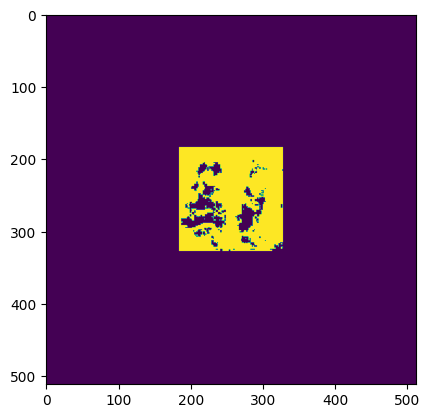

In [42]:
from unetr.utilsUnetr.transforms import CropBedd, RandCropByPosNegLabeld, ResizeOrDoNothingd
from functools import partial
from monai.inferers import sliding_window_inference
from unetr.networks.unetr import UNETR
import os
from unetr.model_module import SegmentationTask
from monai.transforms import LoadImage
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch
from torchvision.utils import save_image
import cv2
import monai.transforms as transforms
import scipy
import os
import glob
import warnings
warnings.filterwarnings("ignore")
from monai import transforms
from monai.transforms import LoadImage
import nibabel as nib
import numpy as np
from pydicom import dcmread
import pandas as pd
import tqdm
import rt_utils
import pydicom
from os import listdir
import tqdm
import json 
from datetime import datetime
import matplotlib.pyplot as plt

meta_data_dir = 'BaseDonnée220Patients/'
pathModelFile = "/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/MetIA/logiciel/trainedModel/checkpoint-epoch=1599-val_loss=0.225.ckpt"


patient_ids = [path.split(os.sep)[-1] for path in glob.glob(os.path.join(meta_data_dir, "*"))]
patient_id_with_meta = list(filter(filter_patients_with_meta, patient_ids))
patient_id_without_meta = list(filter(filter_patients_without_meta, patient_ids))



patient_ids_replace = [path.split(os.sep)[-1].replace(" ", "") for path in glob.glob(os.path.join(meta_data_dir, "*"))]
patient_id_with_meta_replace = []
patient_id_without_meta_replace = []
for i in patient_id_with_meta:
    patient_id_with_meta_replace.append(i.replace(" ", ""))

for i in patient_id_without_meta_replace:
    patient_id_without_meta_replace.append(i.replace(" ", ""))

print(patient_ids,patient_id_with_meta,patient_id_without_meta )



for patient_id in tqdm.tqdm(patient_id_without_meta):
    initial_path = os.path.join(meta_data_dir, patient_id)
    patient_id = patient_id.replace(" ", "")
    try:
        #img, labelGT = load_dicom_series_without_mask(glob.glob(os.path.join(initial_path, "RM"))[0])
        #Si pas de label GrandTruth (RTSTRUCT) remplacer la ligne du dessus par celle ci-dessous
        img = LoadImage("PydicomReader", image_only=True, force=True)((glob.glob(os.path.join(initial_path, "RM"))))
        image, labelPred, imageT = getLabelOfIRM(img, labelGT, pathModelFile)
        #print("patient:",patient_id, diceSpecSens(labelGT, labelPred))
    except Exception as e:
        print("Error with", patient_id)
        print(e)

for patient_id in tqdm.tqdm(patient_id_with_meta):
    initial_path = os.path.join(meta_data_dir, patient_id)
    patient_id = patient_id.replace(" ", "")
    #img, labelGT = load_dicom_with_mask(glob.glob(os.path.join(initial_path, "RM"))[0],glob.glob(os.path.join(initial_path, "META", "*.dcm"))[0],)
    #Si pas de label GrandTruth (RTSTRUCT) remplacer la ligne du dessus par celle ci-dessous
    img=LoadImage("PydicomReader", image_only=True, force=True)((glob.glob(os.path.join(initial_path, "RM"))))
    image, labelPred, imageT = getLabelOfIRM(img, labelGT, pathModelFile)
    plt.imshow(labelPred[0,:,:,150])
    plt.show
    #print("patient:",patient_id, diceSpecSens(labelGT, labelPred))


In [41]:
#faire un carré autour de la méta
import scipy
import cv2

slices_folder='/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/BaseDonnée220Patients/201905984/RM'
mask_file='/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/BaseDonnée220Patients/201905984/META/RS1.2.752.243.1.1.20230601080911063.2000.43828.dcm'
img, mask = load_dicom_with_mask(slices_folder, mask_file)
maskLabels, nbMeta =scipy.ndimage.label(mask)
print("nombre de méta", nbMeta)
center = scipy.ndimage.center_of_mass(mask, maskLabels, index=1)
print(int())
contourz,hierarchy = cv2.findContours(np.array(maskLabels[:,:,center[2]], np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(np.min(np.array(contour)[0,:,0,1]))#335,260

maskCut=mask.copy()
cnt=[[300,500]]
x,y,w,h = cv2.boundingRect(contour[0])
print(x,y,w,h)
maskCut= mask[y:y+h,x:x+w,141]
    
print(np.sum(maskCut), np.sum(mask[:,:,141]))

nombre de méta 1
140
217
309 217 27 44
919.0 919.0


In [ ]:
#tout est condencé sur cette cellule
from unetr.utilsUnetr.transforms import CropBedd, RandCropByPosNegLabeld, ResizeOrDoNothingd
from functools import partial
from monai.inferers import sliding_window_inference
from unetr.networks.unetr import UNETR
import os
from unetr.model_module import SegmentationTask
from monai.transforms import LoadImage
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch
from torchvision.utils import save_image
import cv2
import monai.transforms as transforms
import scipy

dtype= torch.float32
voxel_space =(1.5, 1.5, 2.0)
a_min=-200.0
a_max=300
b_min=0.0
b_max=1.0
clip=True
crop_bed_max_number_of_rows_to_remove=0
crop_bed_max_number_of_cols_to_remove=0
crop_bed_min_spatial_size=(300, -1, -1)
enable_fgbg2indices_feature=False
pos=1.0
neg=1.0
num_samples=1
roi_size=(96, 96, 96)
random_flip_prob=0.2
random_90_deg_rotation_prob=0.2
random_intensity_scale_prob=0.1
random_intensity_shift_prob=0.1
val_resize=(-1, -1, 250)

spacing = transforms.Identity()
if all([space > 0.0 for space in voxel_space]):
    spacing = transforms.Spacingd(
        keys=["image", "label"], pixdim=voxel_space, mode=("bilinear", "nearest")
    ) # to change the dimension of the voxel to have less data to compute
        
    posneg_label_croper_kwargs = {
            "keys": ["image", "label"],
            "label_key": "label",
            "spatial_size": roi_size,
            "pos": pos,
            "neg": neg,
            "num_samples": num_samples,
            "image_key": "image",
            "allow_smaller": True,
    }
    
    fgbg2indices = transforms.Identity()
    if enable_fgbg2indices_feature:
        fgbg2indices = transforms.FgBgToIndicesd(
                keys=["image", "label"], image_key="label", image_threshold=0.0
        ) # to crop samples close to the label mask
        posneg_label_croper_kwargs["fg_indices_key"] = "image_fg_indices"
        posneg_label_croper_kwargs["bg_indices_key"] = "image_bg_indices"
    else:
        posneg_label_croper_kwargs["image_threshold"] = 0.0

train_transform = transforms.Compose(
            [
                transforms.Orientationd(keys=["image", "label"], axcodes="LAS", allow_missing_keys=True), # to have the same orientation
                #spacing,
                transforms.ScaleIntensityRanged(
                    keys=["image"], a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, clip=clip, allow_missing_keys=True
                ), # scales image from a values to b values
                CropBedd(
                    keys=["image", "label"], image_key="image",
                    max_number_of_rows_to_remove=crop_bed_max_number_of_rows_to_remove,
                    max_number_of_cols_to_remove=crop_bed_max_number_of_cols_to_remove,
                    min_spatial_size=crop_bed_min_spatial_size,
                    axcodes_orientation="LAS",
                ), # crop the bed from the image (useless data)
                transforms.CropForegroundd(keys=["image", "label"], source_key="image", allow_missing_keys=True), # remove useless background image part
                fgbg2indices,
                transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=0, allow_missing_keys=True), # random flip on the X axis
                #transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=1, allow_missing_keys=True), # random flip on the Y axis
                #transforms.RandFlipd(keys=["image", "label"], prob=random_flip_prob, spatial_axis=2, allow_missing_keys=True), # random flip on the Z axis
                #transforms.RandRotate90d(keys=["image", "label"], prob=random_90_deg_rotation_prob, max_k=3, allow_missing_keys=True), # random 90 degree rotation
                transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=random_intensity_scale_prob), # random intensity scale
                #transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=random_intensity_shift_prob), # random intensity shifting
                transforms.ToTensord(keys=["image", "label"], dtype=dtype), # to have a PyTorch tensor as output
            ]
        )

file="/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/RunAll4/checkpoints/checkpoint-epoch=1599-val_loss=0.225.ckpt"
model= SegmentationTask.load_from_checkpoint(file)
model.eval()

slices_folder='/home/aurelien/Documents/Segmentation Métastases cérébrales et méningiomes par IA/UNETR/metastase_IA/BaseDonnée220Patients/201905984/RM'
image=torch.tensor([LoadImage(image_only=True)(slices_folder)])
image=((image/np.max(np.array(image)))*255)
image = torch.empty(1,96,96,96)

print("image",image.shape)

image={"image":image, "label":torch.zeros_like(image),"patient_id":'201905984', "has_meta":True}
print("imageDict",image["image"].shape)
image=train_transform(image)#["image"]
print("imageTransfo", image["image"].shape)
#image = train_transform.inverse(image)
#print("imageDeTransfo", image["image"].shape)

labelResult =sliding_window_inference(inputs=image["image"][None], 
                                        roi_size=(96, 96, 96), 
                                        sw_batch_size=4,
                                        predictor=model,
                                        overlap=0.5)

labelPred = torch.argmax(labelResult, dim=1, keepdim=True)
size = labelPred.shape

image["label"]=labelPred.reshape((size[1], size[2], size[3], size[4]))
#image={"image":labelPred, "label":labelPred,"patient_id":'201905984', "has_meta":True}

image = train_transform.inverse(image)

print("imageDeTransfoModel",image["image"].shape, image["label"].shape)

#print("patient:",patient_id, diceSpecSens(labelGT, labelPred))

#info sur les batch voir model_module: training_step MetaFinalItem(image=tensor([[[[[2.7964e+00, 1.8501e+00, 9.1728e-01,  ..., 1.8006e+02,
#, device='cuda:0'), label=tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
#, device='cuda:0'), patient_id=('202105893', '201808172', '202006980', '201911814', '201909977', '202009263', '201806863', '201905116', '202100421', '202004361', '202106842', '201805406', '201907807', '201909889', '201709600', '201807688'), has_meta=tensor([True, True, True, True, True, True, True, True, True, True, True, True,
#        True, True, True, True], device='cuda:0')) torch.Size([16, 1, 96, 96, 96]) torch.Size([16, 1, 96, 96, 96])